# Data processing for the S isotope compositions of porewater profiles from SR2113 samples

In [2]:
# For numerical calculations
import numpy as np
import pandas as pd
import scipy as sp
import math
import matplotlib.animation as animation
from scipy.integrate import odeint
from numpy import arange
from pylab import *
from scipy.integrate import odeint
import scipy.optimize 
from scipy.optimize import leastsq
from math import exp
from collections import OrderedDict
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None
from scipy.signal import savgol_filter
import git

# Import plotting features
import matplotlib.pyplot as plt
import seaborn as sns

# Find home directory for repo
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

# Set plot style
sns.set_style("ticks")
sns.set_palette("colorblind", color_codes=True)
sns.set_context("talk")

# Magic command to plot inline
%matplotlib inline

#To graph in SVG (high def)
%config InlineBackend.figure_format="svg"

In [5]:
# Import table with data
df_data =  pd.read_csv (f'{homedir}/data/raw/EA_SO2_sulfate/20221116_EA.csv')

#Remove NaN cells
df_data = df_data.dropna(subset=['Identifier'])

# Keep only rows with Peak Nr=3, since Peak Nr=1,2,4 and 5 
# correspond to the reference gas
#Select rows to drop
df_data = df_data[df_data.Peak_Nr == 3]

df_data.head()

,Identifier,Peak_Nr,Width,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Date,Core,Depth_cm,Real_depth_cm
2,SW,3,126.7,27.733,758,26.446,1.288,3685,18.810,standard,20221116,NaN,NaN,NaN
7,SW,3,117.3,26.978,770,25.726,1.253,3748,19.296,standard,20221116,NaN,NaN,NaN
12,AGS26,3,157.3,32.366,896,30.856,1.510,4379,23.892,standard,20221116,NaN,NaN,NaN
17,AGS26,3,158.4,47.499,1413,45.281,2.218,6917,25.089,standard,20221116,NaN,NaN,NaN
22,63*,3,172.5,40.318,3660,34.728,5.590,17820,20.886,sample,20221116,CR03,190.0,196.0


Then, let's load the data for the blanks:

In [6]:
# Import table with the raw data for blanks
df_blanks = pd.read_csv(f'{homedir}/data/raw/EA_SO2_sulfate/20221116_blanks.csv')
# Remove rows with missing data
df_blanks.dropna(how='any', inplace=True)
# Keep only rows with Peak Nr=3
df_blanks = df_blanks[df_blanks.Peak_Nr == 3]
#Drop outliers in place
df_blanks.drop(df_blanks.index[2], inplace=True)
df_blanks.drop(df_blanks.index[0], inplace=True)
df_blanks

,Identifier,Peak_Nr,Width,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Date
7,blank,3,86.7,5.160,180,4.922,0.239,872,14.370,20220216
17,blank,3,81.4,3.249,105,3.099,0.150,507,13.313,20220216
22,blank,3,82.1,3.687,131,3.516,0.171,636,15.437,20220216


Finally, let's load the data for the linearity test at the beginning of the run:

In [7]:
# Import file
df_lin =  pd.read_csv(f'{homedir}/data/raw/EA_SO2_sulfate/20221116_linearity.csv')
df_lin.head()

,Identifier,Peak_Nr,Width,Ampl_64,Ampl_66,d34S
0,linearity,1,42.0,543,2598,-0.124
1,linearity,2,47.4,1816,8695,0.000
2,linearity,3,50.4,2735,13093,0.121
3,linearity,4,52.2,3317,15880,0.167
4,linearity,5,54.3,4526,21674,0.316


Now, let's implement the corrections.

## Blank correction

In [8]:
# Get the average area all for the blanks
blank_area_all_average = df_blanks["Area_All"].mean()

# Get the average d34S for the blanks
blank_d34s_average = df_blanks["d34S"].mean()

# Append a column to the data dataframe with the 
# correction of area by blank: substraction of the
# area of the measurement by the area of the blank

df_data['Correction_of_area_blank'] = \
    np.subtract(df_data['Area_All'], blank_area_all_average)

# Correction of d34S by blank: 
    
# Get the product of the d34S by the area of each measurement
num1 = np.multiply (df_data['d34S'], df_data['Area_All'])
# Get the product of the d34S by the area of the average of the blanks
num2 = blank_d34s_average * blank_area_all_average  
#Subtract the product of d34S by the product of the blanks
num = np.subtract (num1, num2)
#Divide by the area corrected by blank and
#append column to the data dataframe
df_data['Correction_of_d34S_blank'] = \
    np.divide (num, df_data['Correction_of_area_blank'])

df_data.head()

,Identifier,Peak_Nr,Width,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Date,Core,Depth_cm,Real_depth_cm,Correction_of_area_blank,Correction_of_d34S_blank
2,SW,3,126.7,27.733,758,26.446,1.288,3685,18.810,standard,20221116,NaN,NaN,NaN,23.701,19.564763
7,SW,3,117.3,26.978,770,25.726,1.253,3748,19.296,standard,20221116,NaN,NaN,NaN,22.946,20.160996
12,AGS26,3,157.3,32.366,896,30.856,1.510,4379,23.892,standard,20221116,NaN,NaN,NaN,28.334,25.246530
17,AGS26,3,158.4,47.499,1413,45.281,2.218,6917,25.089,standard,20221116,NaN,NaN,NaN,43.467,26.082986
22,63*,3,172.5,40.318,3660,34.728,5.590,17820,20.886,sample,20221116,CR03,190.0,196.0,36.286,21.609670


## Linearity correction

In [9]:
# Create variables for linear regression
# x will be the amplitude of the peak of mass 64 = ^32S + ^16O + ^16O
# We divided by 1000 to convert volts ot milivolts
x = (df_lin['Ampl_64'].values/1000).reshape((-1,1))
# y will be the values of d34S
y = (df_lin['d34S'])

# Create model of linear regression
model = LinearRegression().fit(x,y)

#Determine R square, intercept and slope
r_sq = model.score(x,y)
intercept = model.intercept_
s = model.coef_
slope=s[0]

# Calculate an amplitude difference by centering around an arbitrary 
# value in the Ampl_64 column of the data dataframe  
num= np.subtract(df_data['Ampl_64'], 800)
ampl_difference = np.divide (num, 1000)

# Calculate the amplitude correction factor
ampl_correction_factor = (slope * ampl_difference)+intercept

# Correct the d34S corrected by amplitude by
# subtracting the blank corrected data by the amplitude correction
# factor and append the column to the data dataframe
df_data['Correction_of_d34S_by_amplitude'] = \
    np.subtract(df_data['Correction_of_d34S_blank'], ampl_correction_factor)

df_data.head()

,Identifier,Peak_Nr,Width,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Date,Core,Depth_cm,Real_depth_cm,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude
2,SW,3,126.7,27.733,758,26.446,1.288,3685,18.810,standard,20221116,NaN,NaN,NaN,23.701,19.564763,19.710151
7,SW,3,117.3,26.978,770,25.726,1.253,3748,19.296,standard,20221116,NaN,NaN,NaN,22.946,20.160996,20.305360
12,AGS26,3,157.3,32.366,896,30.856,1.510,4379,23.892,standard,20221116,NaN,NaN,NaN,28.334,25.246530,25.380150
17,AGS26,3,158.4,47.499,1413,45.281,2.218,6917,25.089,standard,20221116,NaN,NaN,NaN,43.467,26.082986,26.172518
22,63*,3,172.5,40.318,3660,34.728,5.590,17820,20.886,sample,20221116,CR03,190.0,196.0,36.286,21.609670,21.507588


## Standard correction 

In [10]:
# Create df with only standard data
df_standards = df_data[(df_data.Type == 'standard')] 
#Sort values by ID and area
df_standards = df_standards.sort_values(['Identifier', 'Area_All'])

df_standards

,Identifier,Peak_Nr,Width,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Date,Core,Depth_cm,Real_depth_cm,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude
87,AGS26,3,127.4,17.009,516,16.217,0.792,2519,21.937,standard,20221116,NaN,NaN,NaN,12.977,24.287058,24.453083
182,AGS26,3,180.0,27.691,709,26.400,1.291,3463,23.521,standard,20221116,NaN,NaN,NaN,23.659,25.079958,25.229525
272,AGS26,3,153.9,29.938,808,28.541,1.397,3952,23.689,standard,20221116,NaN,NaN,NaN,25.906,25.138887,25.280011
177,AGS26,3,150.3,30.673,977,29.242,1.431,4777,24.028,standard,20221116,NaN,NaN,NaN,26.641,25.489192,25.615905
12,AGS26,3,157.3,32.366,896,30.856,1.510,4379,23.892,standard,20221116,NaN,NaN,NaN,28.334,25.246530,25.380150
92,AGS26,3,180.1,38.828,1062,37.016,1.811,5190,24.546,standard,20221116,NaN,NaN,NaN,34.796,25.724762,25.844226
277,AGS26,3,179.6,39.979,1115,38.113,1.867,5457,24.778,standard,20221116,NaN,NaN,NaN,35.947,25.945041,26.059985
17,AGS26,3,158.4,47.499,1413,45.281,2.218,6917,25.089,standard,20221116,NaN,NaN,NaN,43.467,26.082986,26.172518
77,SW,3,122.9,26.345,709,25.121,1.224,3454,19.293,standard,20221116,NaN,NaN,NaN,22.313,20.181993,20.331559
7,SW,3,117.3,26.978,770,25.726,1.253,3748,19.296,standard,20221116,NaN,NaN,NaN,22.946,20.160996,20.305360


In [11]:
#Drop outliers in place
df_standards.drop(df_standards.index[11], inplace=True)
df_standards.drop(df_standards.index[0], inplace=True)

# Calculate the slope and intercept for calculated vs. true value of the stds

# Append true value column to the standard table
# For AGS2
df_standards.loc[df_standards['Identifier'] \
                  == 'AGS26', 'True_d34S'] = 26.83
# For SW
df_standards.loc[df_standards['Identifier'] \
                  == 'SW', 'True_d34S'] = 21

df_standards

,Identifier,Peak_Nr,Width,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Date,Core,Depth_cm,Real_depth_cm,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,True_d34S
182,AGS26,3,180.0,27.691,709,26.400,1.291,3463,23.521,standard,20221116,NaN,NaN,NaN,23.659,25.079958,25.229525,26.83
272,AGS26,3,153.9,29.938,808,28.541,1.397,3952,23.689,standard,20221116,NaN,NaN,NaN,25.906,25.138887,25.280011,26.83
177,AGS26,3,150.3,30.673,977,29.242,1.431,4777,24.028,standard,20221116,NaN,NaN,NaN,26.641,25.489192,25.615905,26.83
12,AGS26,3,157.3,32.366,896,30.856,1.510,4379,23.892,standard,20221116,NaN,NaN,NaN,28.334,25.246530,25.380150,26.83
92,AGS26,3,180.1,38.828,1062,37.016,1.811,5190,24.546,standard,20221116,NaN,NaN,NaN,34.796,25.724762,25.844226,26.83
277,AGS26,3,179.6,39.979,1115,38.113,1.867,5457,24.778,standard,20221116,NaN,NaN,NaN,35.947,25.945041,26.059985,26.83
17,AGS26,3,158.4,47.499,1413,45.281,2.218,6917,25.089,standard,20221116,NaN,NaN,NaN,43.467,26.082986,26.172518,26.83
77,SW,3,122.9,26.345,709,25.121,1.224,3454,19.293,standard,20221116,NaN,NaN,NaN,22.313,20.181993,20.331559,21.00
7,SW,3,117.3,26.978,770,25.726,1.253,3748,19.296,standard,20221116,NaN,NaN,NaN,22.946,20.160996,20.305360,21.00
82,SW,3,123.2,27.157,762,25.895,1.262,3712,19.422,standard,20221116,NaN,NaN,NaN,23.125,20.302269,20.447316,21.00


In [12]:
# Get the slope and intercept for the standards 
# Define column names
names = ['R squared', 'Intercept', 'Slope']

# Initialize empty dataframe to save fit results
df_linreg_stds = pd.DataFrame(columns=names)
                 
# Create variables for linear regression
#x will be the values of d34S of the stds corrected by blanks and linearity
x_std = df_standards.Correction_of_d34S_by_amplitude.values.reshape((-1,1))
#y will be the true values of d34S of each standard
y_std = df_standards.True_d34S
# Create model
model = LinearRegression().fit(x_std,y_std)
#Determine R square, intercept and slope
r_sq_stds = model.score(x_std,y_std)
intercept_stds = model.intercept_
s1 = model.coef_
slope_stds = s1[0]
# Store parameters and group as list
params = (r_sq_stds, intercept_stds, slope_stds)
 
# Convert list to pandas Series
series = pd.Series(params, index=names)   
# Append parameters to dataframe
df_linreg_stds = df_linreg_stds.append(series, ignore_index=True)
#Round the values of the dataframe to two decimal places
df_linreg_stds = df_linreg_stds.round(2)     
df_linreg_stds 

,R squared,Intercept,Slope
0,0.99,-1.82,1.12


In [13]:
#Apply corrections by true value

# Initialize lists to save values
slopes = []
intercepts = []
Correction_of_d34S_by_true_value = []

#loop through rows in dataframe
for index, row in df_data.iterrows():
    # Extract slope and intercept
    slope = df_linreg_stds.Slope.iloc[0]
    intercept = df_linreg_stds.Intercept.iloc[0]
    slopes.append(slope)
    intercepts.append(intercept)
    # Compute corrected concentration
    Correction_of_d34S_by_true_value.append((intercept + slope * row.Correction_of_d34S_by_amplitude))
    
# Append values to dataframe
df_data['Correction_of_d34S_by_true_value'] = Correction_of_d34S_by_true_value

df_data.head()

,Identifier,Peak_Nr,Width,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Date,Core,Depth_cm,Real_depth_cm,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Correction_of_d34S_by_true_value
2,SW,3,126.7,27.733,758,26.446,1.288,3685,18.810,standard,20221116,NaN,NaN,NaN,23.701,19.564763,19.710151,20.255369
7,SW,3,117.3,26.978,770,25.726,1.253,3748,19.296,standard,20221116,NaN,NaN,NaN,22.946,20.160996,20.305360,20.922004
12,AGS26,3,157.3,32.366,896,30.856,1.510,4379,23.892,standard,20221116,NaN,NaN,NaN,28.334,25.246530,25.380150,26.605768
17,AGS26,3,158.4,47.499,1413,45.281,2.218,6917,25.089,standard,20221116,NaN,NaN,NaN,43.467,26.082986,26.172518,27.493220
22,63*,3,172.5,40.318,3660,34.728,5.590,17820,20.886,sample,20221116,CR03,190.0,196.0,36.286,21.609670,21.507588,22.268498


Since all the corrections have been done, we will now export the corrected data.

In [14]:
# Create dataframe that includes only data from the samples
df_samples = df_data[(df_data.Type == 'sample')]
#Sort by depth
df_samples = df_samples.sort_values(['Core','Real_depth_cm'])

# Export data table
df_samples.to_csv(f'{homedir}/data/processed/EA_SO2_sulfate/20221116_EA.csv')
df_samples

,Identifier,Peak_Nr,Width,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Date,Core,Depth_cm,Real_depth_cm,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Correction_of_d34S_by_true_value
187,43,3,180.1,48.361,1482,46.112,2.249,7221,19.802,sample,20221116,CR02,3.0,6.5,44.329,20.295771,20.379420,21.004950
207,19,3,180.0,66.648,2049,63.548,3.100,9986,19.909,sample,20221116,CR02,15.0,18.5,62.616,20.265455,20.300753,20.916843
202,23,3,180.0,57.156,1507,54.498,2.659,7344,20.062,sample,20221116,CR02,21.0,24.5,53.124,20.493758,20.575274,21.224307
72,30,3,170.9,43.350,1272,41.333,2.016,6200,19.730,sample,20221116,CR02,30.0,33.5,39.318,20.279318,20.380874,21.006579
112,46,3,175.4,34.218,1008,32.627,1.591,4906,19.888,sample,20221116,CR02,42.0,45.5,30.186,20.624604,20.748673,21.418514
122,33,3,180.1,41.819,1255,39.875,1.944,6112,20.177,sample,20221116,CR02,51.0,54.5,37.787,20.796271,20.899277,21.587190
212,18,3,180.0,64.025,1712,61.048,2.977,8344,20.201,sample,20221116,CR02,54.0,57.5,59.993,20.592665,20.656700,21.315504
147,31,3,171.5,44.559,1219,42.487,2.072,5941,20.364,sample,20221116,CR02,57.0,60.5,40.527,20.960007,21.066083,21.774013
52,29,3,158.7,46.197,1271,44.049,2.148,6193,20.236,sample,20221116,CR02,60.0,63.5,42.165,20.796614,20.898255,21.586046
127,35,3,156.4,40.721,1273,38.829,1.893,6199,20.311,sample,20221116,CR02,63.0,66.5,36.689,20.963530,21.065001,21.772801


### Analytical repeatability of measurements

Let's calculate the analytical repeatability of the EA-IRMS measurements. 

In [15]:
# Update standard df
# Create a dataframe for only standards from the updated data dataframe
df_standards = df_data[(df_data.Type == 'standard')]
df_standards.head()

,Identifier,Peak_Nr,Width,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Date,Core,Depth_cm,Real_depth_cm,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Correction_of_d34S_by_true_value
2,SW,3,126.7,27.733,758,26.446,1.288,3685,18.810,standard,20221116,NaN,NaN,NaN,23.701,19.564763,19.710151,20.255369
7,SW,3,117.3,26.978,770,25.726,1.253,3748,19.296,standard,20221116,NaN,NaN,NaN,22.946,20.160996,20.305360,20.922004
12,AGS26,3,157.3,32.366,896,30.856,1.510,4379,23.892,standard,20221116,NaN,NaN,NaN,28.334,25.246530,25.380150,26.605768
17,AGS26,3,158.4,47.499,1413,45.281,2.218,6917,25.089,standard,20221116,NaN,NaN,NaN,43.467,26.082986,26.172518,27.493220
77,SW,3,122.9,26.345,709,25.121,1.224,3454,19.293,standard,20221116,NaN,NaN,NaN,22.313,20.181993,20.331559,20.951346


In [16]:
#Drop outliers in place
df_standards.drop(df_standards.index[6], inplace=True)
df_standards.drop(df_standards.index[0], inplace=True)
#Sort values
df_standards = df_standards.sort_values(['Identifier', 'Area_All'])

#Group standards by identifier 
grouped_standards = df_standards.groupby(['Identifier'])

# Determine the mean of each standard  and rename the series
mean_stds = grouped_standards['Correction_of_d34S_by_true_value'].mean()
mean_stds = mean_stds.rename("d34S_mean")

# Determine the standard deviation of each standard  and rename the series
std_dev_stds = grouped_standards['Correction_of_d34S_by_true_value'].std()
std_dev_stds = std_dev_stds.rename("d34S_stdev")

#Pass series to individual dataframes
df_mean_stds=mean_stds.to_frame()
df_std_dev_stds=std_dev_stds.to_frame()


In [17]:
#merge the mean and standard deviation dataframes
df_anrep = pd.merge(df_mean_stds, df_std_dev_stds,  how='outer', on=['Identifier'])

#Reset index of the dataframe
df_anrep = df_anrep.reset_index()

#Add column of true value of the standards
df_anrep.loc[df_anrep['Identifier'] \
                  == 'AGS26', 'True_d34S'] = 26.83
df_anrep.loc[df_anrep['Identifier'] \
                  == 'SW', 'True_d34S'] = 21

#Determine the accuracy by subtracting the true value from the average value of each standard
df_anrep ['Accuracy'] = abs(df_anrep ['True_d34S'] - df_anrep ['d34S_mean'])
df_anrep

,Identifier,d34S_mean,d34S_stdev,True_d34S,Accuracy
0,AGS26,26.913171,0.425590,26.83,0.083171
1,SW,21.120580,0.154114,21.00,0.120580


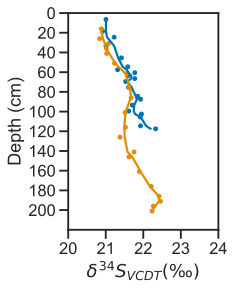

In [18]:
#Plot the S isotope data
# Group data by core
grouped = df_samples.groupby('Core')
#Make plot
fig, ax = plt.subplots(figsize=(2.7,4))
for i, (group,data) in enumerate(grouped):
    # Get Unique core labels
    color_labels = sort(df_samples['Core'].unique())
    # Define colors
    colors = sns.color_palette("colorblind", len(color_labels))
    # Create dictionary that pairs core labels with colors
    color_map = dict(zip(color_labels, colors))
    # Map core labels to the colors
    color = data['Core'].map(color_map)
    
    #Make errorbar plot
    ax.scatter(data['Correction_of_d34S_by_true_value'], data['Real_depth_cm'], s=12)
    
    #Create a Savitzky-Golay filter. It uses least squares to regress a small window of your data onto a polynomial, 
    #then uses the polynomial to estimate the point in the center of the window. Finally the window is shifted forward 
    #by one data point and the process repeats. This continues until every point has been optimally adjusted relative 
    #to its neighbors. It works great even with noisy samples from non-periodic and non-linear sources.
    xhat = savgol_filter(data['Correction_of_d34S_by_true_value'], 9, 4, mode='nearest') # window size 51, polynomial order 3
    
    #Plot the Savitzky-Golay curve for each core on top of the scatter plots
    ax.plot(xhat, data['Real_depth_cm'], color=colors[i])
    
    # Set plot title
    #ax.set_title('Oxygen', fontsize =16)

    #Invert y axis
    ax.invert_yaxis()
    ax.set_xlabel('$\delta^{34}S_{VCDT} (‰)$')
    ax.set_ylabel('Depth (cm)')
    ax.set_yticks(np.arange(0, 220, 20.0))
    ax.set_ylim(220, 0)
    ax.set_xticks(np.linspace(20, 24, 5).round(0))
#ax.legend(bbox_to_anchor=(0.5, -0.25), ncol=4, loc = 'lower center')

#Save figure
fig.savefig(f'{homedir}/figures/s_isotopes_sulfate_talk.pdf', bbox_inches='tight')

In [30]:
# Load the oxygen isotope data
# Import csv file
df_oxygen = pd.read_csv(f'{homedir}/data/raw/EA_SO2_sulfate/O_Sulfate_isotopes.csv')
df_oxygen = df_oxygen.sort_values('Real_depth_cm')
df_oxygen = df_oxygen.rename(columns={"ID": "Identifier"})
#See dataframe
df_oxygen.head()

,Identifier,Core,Depth,d18O,d18O_sd,Real_depth_cm,Measurement
18,58,CR03,10,8.732701,0.254107,16.0,Oxygen
0,19,CR02,15,8.190571,0.129726,18.5,Oxygen
1,23,CR02,21,8.238678,0.317521,24.5,Oxygen
19,78,CR03,20,9.048273,0.151675,26.0,Oxygen
20,79,CR03,25,8.983339,0.098331,31.0,Oxygen


In [38]:
df_samples.head()

,Identifier,Peak_Nr,Width,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Date,Core,Depth_cm,Real_depth_cm,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Correction_of_d34S_by_true_value
187,43,3,180.1,48.361,1482,46.112,2.249,7221,19.802,sample,20221116,CR02,3.0,6.5,44.329,20.295771,20.379420,21.004950
207,19,3,180.0,66.648,2049,63.548,3.100,9986,19.909,sample,20221116,CR02,15.0,18.5,62.616,20.265455,20.300753,20.916843
202,23,3,180.0,57.156,1507,54.498,2.659,7344,20.062,sample,20221116,CR02,21.0,24.5,53.124,20.493758,20.575274,21.224307
72,30,3,170.9,43.350,1272,41.333,2.016,6200,19.730,sample,20221116,CR02,30.0,33.5,39.318,20.279318,20.380874,21.006579
112,46,3,175.4,34.218,1008,32.627,1.591,4906,19.888,sample,20221116,CR02,42.0,45.5,30.186,20.624604,20.748673,21.418514


In [39]:
#merge the mean and standard deviation dataframes
df_isotopes = pd.merge(df_oxygen, df_samples,  how='outer', on=['Core','Real_depth_cm'])
#Reset index of the dataframe
df_isotopes = df_isotopes.reset_index()
# Convert d18O to float
df_isotopes = df_isotopes.astype({"d18O": float})
df_isotopes.head()

,index,Identifier_x,Core,Depth,d18O,d18O_sd,Real_depth_cm,Measurement,Identifier_y,Peak_Nr,...,Area_66,Ampl_66,d34S,Type,Date,Depth_cm,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Correction_of_d34S_by_true_value
0,0,58.0,CR03,10.0,8.732701,0.254107,16.0,Oxygen,58,3.0,...,3.650,11255.0,19.957,sample,20221116.0,10.0,74.396,20.259615,20.272826,20.885565
1,1,19.0,CR02,15.0,8.190571,0.129726,18.5,Oxygen,19,3.0,...,3.100,9986.0,19.909,sample,20221116.0,15.0,62.616,20.265455,20.300753,20.916843
2,2,23.0,CR02,21.0,8.238678,0.317521,24.5,Oxygen,23,3.0,...,2.659,7344.0,20.062,sample,20221116.0,21.0,53.124,20.493758,20.575274,21.224307
3,3,78.0,CR03,20.0,9.048273,0.151675,26.0,Oxygen,78,3.0,...,2.926,8699.0,19.801,sample,20221116.0,20.0,58.867,20.172759,20.230569,20.838237
4,4,79.0,CR03,25.0,8.983339,0.098331,31.0,Oxygen,79,3.0,...,2.206,5782.0,19.823,sample,20221116.0,25.0,43.387,20.329443,20.438248,21.070838


In [101]:
#Create linear regression group empty list
lin_reg = []
# Classify the area of the samples by category 
# Loop through dataframe rows
for i,row in df_isotopes.iterrows():
    if row['Core'] == 'CR02':
        lin_reg.append ('CR02')
    elif ((row['d18O']<9.7) and (row['Core'] == 'CR03')):
        lin_reg.append ('CR03_low')
    else:
        lin_reg.append ('CR03_high')       
# Append to data dataframe 
df_isotopes['lin_reg'] = lin_reg
df_isotopes.head()

,index,Identifier_x,Core,Depth,d18O,d18O_sd,Real_depth_cm,Measurement,Identifier_y,Peak_Nr,...,Ampl_66,d34S,Type,Date,Depth_cm,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Correction_of_d34S_by_true_value,lin_reg
0,0,58.0,CR03,10.0,8.732701,0.254107,16.0,Oxygen,58,3.0,...,11255.0,19.957,sample,20221116.0,10.0,74.396,20.259615,20.272826,20.885565,CR03_low
1,1,19.0,CR02,15.0,8.190571,0.129726,18.5,Oxygen,19,3.0,...,9986.0,19.909,sample,20221116.0,15.0,62.616,20.265455,20.300753,20.916843,CR02
2,2,23.0,CR02,21.0,8.238678,0.317521,24.5,Oxygen,23,3.0,...,7344.0,20.062,sample,20221116.0,21.0,53.124,20.493758,20.575274,21.224307,CR02
3,3,78.0,CR03,20.0,9.048273,0.151675,26.0,Oxygen,78,3.0,...,8699.0,19.801,sample,20221116.0,20.0,58.867,20.172759,20.230569,20.838237,CR03_low
4,4,79.0,CR03,25.0,8.983339,0.098331,31.0,Oxygen,79,3.0,...,5782.0,19.823,sample,20221116.0,25.0,43.387,20.329443,20.438248,21.070838,CR03_low


In [113]:
# Get the the slope of the tangent on the δ18OSO4 vs. δ34SSO4
# Define column names
names = ['lin_reg','R squared', 'Intercept', 'Slope']

#Filter by non NaN
df_filtered = df_isotopes.dropna()
# Group by lin reg group
df_group = df_filtered.groupby (['lin_reg'])

# Initialize empty dataframe to save fit results
df_linreg = pd.DataFrame(columns=names)
                 
# Create variables for linear regression
#Loop through standard groups                       
for group, data in enumerate (df_group):
    #x will be the Correction_of_d34S_by_true_value
    x_std = data[1].Correction_of_d34S_by_true_value.values.reshape((-1,1))
    #y will be the d180
    y_std = data[1].d18O
    # Create model
    model = LinearRegression().fit(x_std,y_std)
    #Determine R square, intercept and slope
    r_sq_stds = model.score(x_std,y_std)
    intercept_stds = model.intercept_
    s1 = model.coef_
    slope_stds = s1[0]
    # Store parameters and group as list
    params = (data[1].lin_reg.unique(), r_sq_stds, intercept_stds, slope_stds)
    # Convert list to pandas Series
    series = pd.Series(params, index=names)   
    # Append parameters to dataframe
    df_linreg = df_linreg.append(series, ignore_index=True)
#Round the values of the dataframe to two decimal places
#df_linreg = df_linreg.round(2)     
df_linreg

,lin_reg,R squared,Intercept,Slope
0,[CR02],0.705433,-16.226410,1.173502
1,[CR03_high],0.853925,-12.870569,1.067901
2,[CR03_low],0.439775,-2.583572,0.548296


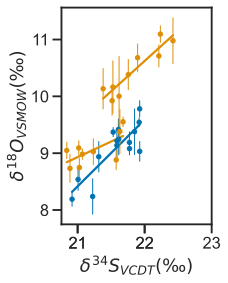

In [127]:
#Crossplot of the S vs. O isotope data
# Group data by core
grouped = df_filtered.groupby('lin_reg')
#Make plot
fig, ax = plt.subplots(figsize=(2.7,4))
for i, (group,data) in enumerate(grouped):
    # Get Unique core labels
    color_labels = sort(df_isotopes['lin_reg'].unique())
    # Define colors
    colors = ('#0173b2', '#de8f05', '#de8f05')
    # Create dictionary that pairs core labels with colors
    color_map = dict(zip(color_labels, colors))
    # Map core labels to the colors
    color = data['Core'].map(color_map)
    # Loop through replicates
    
    #Calculate trendline  
    z = np.polyfit(data.Correction_of_d34S_by_true_value, data.d18O, 1)
    p = np.poly1d(z)
 
    # Plot fit
    ax.plot(data.Correction_of_d34S_by_true_value, p(data.Correction_of_d34S_by_true_value), c=colors[i])
    
    #Make errorbar plot
    ax.errorbar(data['Correction_of_d34S_by_true_value'], data['d18O'], yerr=data['d18O_sd'], fmt ='.', elinewidth=1, c=colors[i])

    
    # Set plot title
    #ax.set_title('Oxygen', fontsize =16)

    ax.set_xlabel('$\delta^{34}S_{VCDT} (‰)$')
    ax.set_ylabel('$\delta^{18}O_{VSMOW} (‰)$')
    #ax.set_xticks(np.linspace(20, 23, 5).round(0))
    ax.set_xticks(np.linspace((ax.get_xbound()[0]), (ax.get_xbound()[1]), 5).round(0))

#ax.legend(bbox_to_anchor=(0.5, -0.25), ncol=4, loc = 'lower center')

#Save figure
fig.savefig(f'{homedir}/figures/crossplot_isotopes_sulfate.pdf', bbox_inches='tight')